In [2]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
from glob import glob
import gzip
import csv
import gc
import re
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def spellProcessor(word):
    word = word.lower()
    word = word.replace("gyftis", "gifts")
    word = word.replace("gether", "gather")
    word = word.replace("spirituall", "spiritual")
    word = word.replace("feythfull", "faith")
    word = word.replace("wytnes", "witness")
    word = word.replace("almes", "alms")
    word = word.replace("desyre", "desire")
    word = word.replace("selfe", "self")
    word = word.replace("saffely", "safely")
    word = word.replace("realme", "realm")
    word = word.replace("acte", "act")
    word = word.replace("fourme", "form")
    word = word.replace("subiectes", "subjects")
    word = word.replace("theyr", "their")
    word = word.replace("kynde", "kind")
    word = word.replace("kynge", "king")
    word = word.replace("kyndes", "kinds")
    word = word.replace("vpon", "unto")
    word = word.replace("purueyours", "purveyors")
    word = word.replace("highnes", "highness")
    word = word.replace("euery", "every")
    word = word.replace("quene", "queen")
    word = word.replace("quenes", "queens")
    word = word.replace("whiche", "which")
    word = word.replace("bloude", "blood")
    word = word.replace("soueraine", "sovereign")
    word = word.replace("enactd", "enacted")
    word = word.replace("vs", "us")
    
    word = re.sub('\d','', word)
    return word

stopWords = [",","the","and","of","or","to","in","shall","be","that","any","by",".",
              "such","as","this","for","same","all","said","other","'s",";",
              "her","is","every","[","]","they","within", "our", "not", "so",
              "made", "no", "then", ":", "do", "from", "if", "it", "which", "at", "with",
             "thereof","upon", "a", "because", "used", "some", "but", "aforesaid", "also",
             ")","(", "what", "&", "may", "are", "their", "them", "sayde", "suche", "shalbe", "anye", "sayd",
             "thesaid", "/", "...", "/", "either", "haue", "vnto", "thy", "did", "was", "were", "have", "thee", 
             "your", "thou", "unto", "hath", "had", "went","kl"]

In [4]:
def extract_five_grams(term):
    words = list()
    for i, idx in vectorizer.vocabulary_.items():
        i = i.split()
        if i[2] == term:
            # get sums
            vocab_sums = dtm.sum(axis=0)
            count = (vocab_sums[0, idx]) 
            for j in range(count):
                words.append(i[0])
                words.append(i[1])
                words.append(i[3])
                words.append(i[4])
    return(words)

In [5]:
input_data = list()
row_count = 0

metadata=list()
with open('../vtexts/vtextMetadata.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # deal with the header
        if row_count != 0:
            metadata.append(row)   
        row_count += 1
print("read",row_count,"lines")

# extract crown list
labels = [i[3] for i in metadata]

read 69 lines


In [6]:
# Define our term of interest

key_term = "religion"

# we'll search for five-grams with this word as the center word:
# [term1,term2,key_term,term4,term5]

In [7]:
# collect data 
five_gram_data = dict()
for i, c in enumerate(set(labels)):
    
    # re-establisher vectorizer
    vectorizer = CountVectorizer(
        input='filename',
        lowercase=True,
        ngram_range=(5,5),
        preprocessor=spellProcessor,
        stop_words=stopWords)

    print("starting: {0}".format(c))

    files = list()
    for m in metadata:
        if m[3] == c:
            files.append("../texts/" + m[0])
    
    # vectorize model
    print(" vectorizing...")
    dtm = vectorizer.fit_transform(files)

    print(" extracting five-gram terms...")
    terms = extract_five_grams(key_term)
    five_gram_data[c] = terms
    
    # free memory
    del vectorizer, dtm
    gc.collect()

starting: Henry VIII
 vectorizing...
 extracting five-gram terms...
starting: Mary I
 vectorizing...
 extracting five-gram terms...
starting: James I
 vectorizing...
 extracting five-gram terms...
starting: Edward VI
 vectorizing...
 extracting five-gram terms...
starting: Elizabeth I
 vectorizing...
 extracting five-gram terms...
starting: Charles I
 vectorizing...
 extracting five-gram terms...


In [8]:
# now collect frequencies
crown_frequencies = dict()

for y in five_gram_data:
    t = list()
    w = set(five_gram_data[y])
    for i in w:
        t.append([i,five_gram_data[y].count(i)])
    crown_frequencies[y] = t

In [9]:
def graph_data(key_term,crown):
    G = nx.Graph()
    node_list = list()
    labels=dict()
    
    for t, w in sorted(crown_frequencies[crown], key=lambda x: x[1], reverse=True)[:15]:
        G.add_node(t)
        node_list.append(t)
        G.add_edge(key_term,t,weight=w)
        labels[t] = t
   
    plt.figure(figsize=(15,12))

    pos=nx.spring_layout(G,scale=2) 
    nx.draw_networkx_nodes(G,pos,node_color='lightblue',node_size=1500)
    nx.draw_networkx_labels(G,pos,labels,font_size=10)

    all_weights = []
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight'])
    unique_weights = list(set(all_weights))

    for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) 
                          if edge_attr['weight']==weight]
        width = weight*len(node_list)*3.0/sum(all_weights)
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width)
    plt.show()

In [10]:
def bar_graph(key_term,crown):
    labels = [x[0] for x in sorted(crown_frequencies[crown], key=lambda x: x[1], reverse=True)[:15]]
    data = [x[1] for x in sorted(crown_frequencies[crown], key=lambda x: x[1], reverse=True)[:15]]
    title = "{0}: {1}".format(key_term,crown)
    plt.rcdefaults()
    ig, ax = plt.subplots()
    y = np.arange(len(data))
    ax.barh(y, data)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis() 
    plt.title(title)
    plt.show()

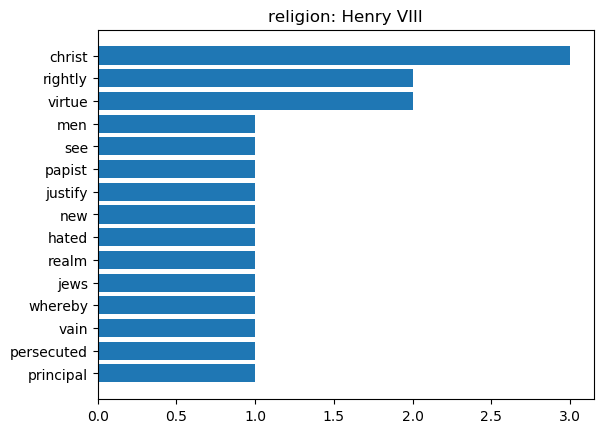

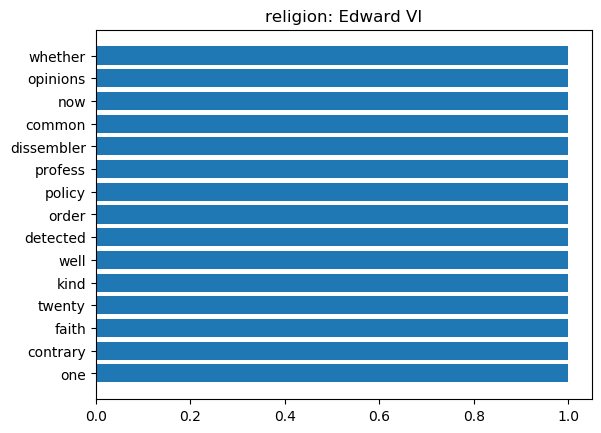

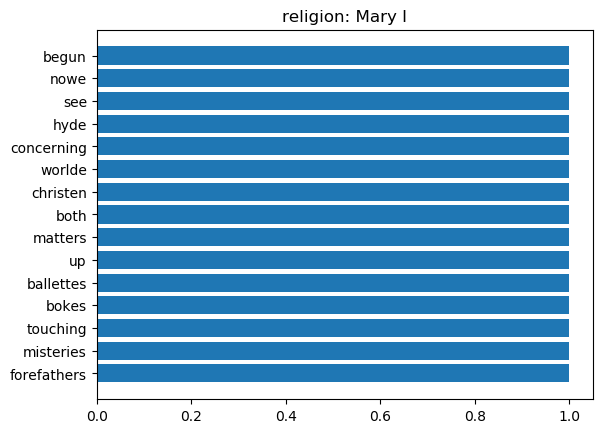

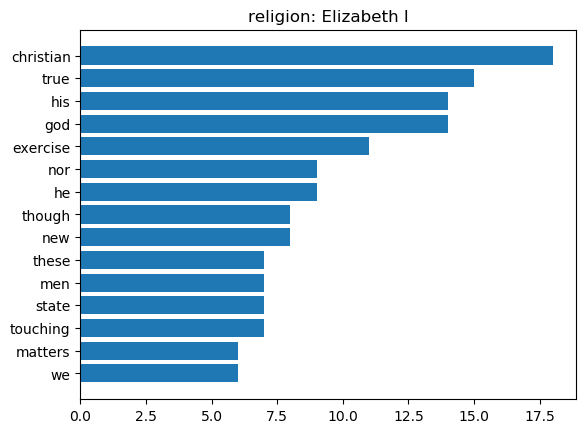

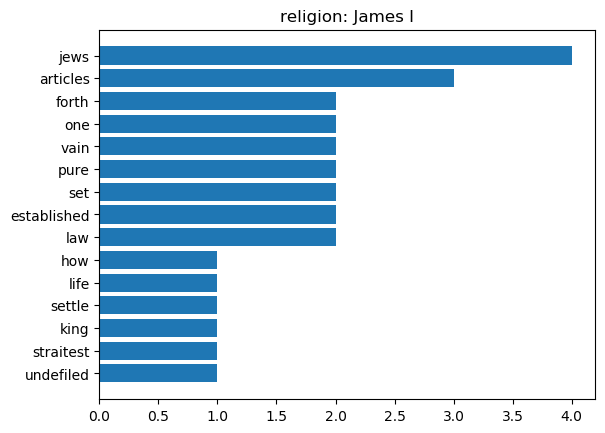

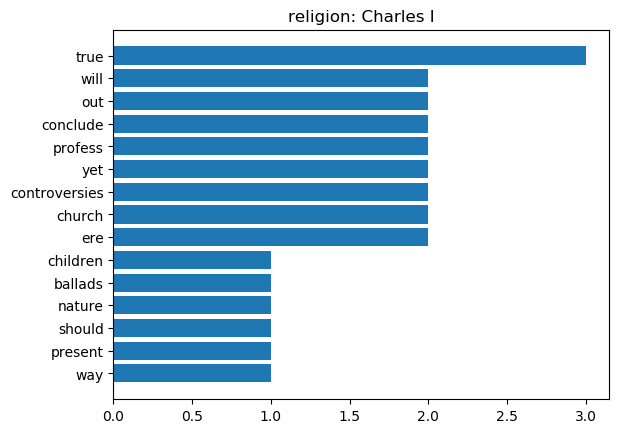

In [11]:
# extract correct ordering?
for crown in ["Henry VIII","Edward VI", "Mary I","Elizabeth I","James I","Charles I"]:
    bar_graph(key_term,crown)

Crown: Class
-------------------
Henry VIII: 2
Edward VI: 2
Mary I: 2
Elizabeth I: 1
James I: 2
Charles I: 0


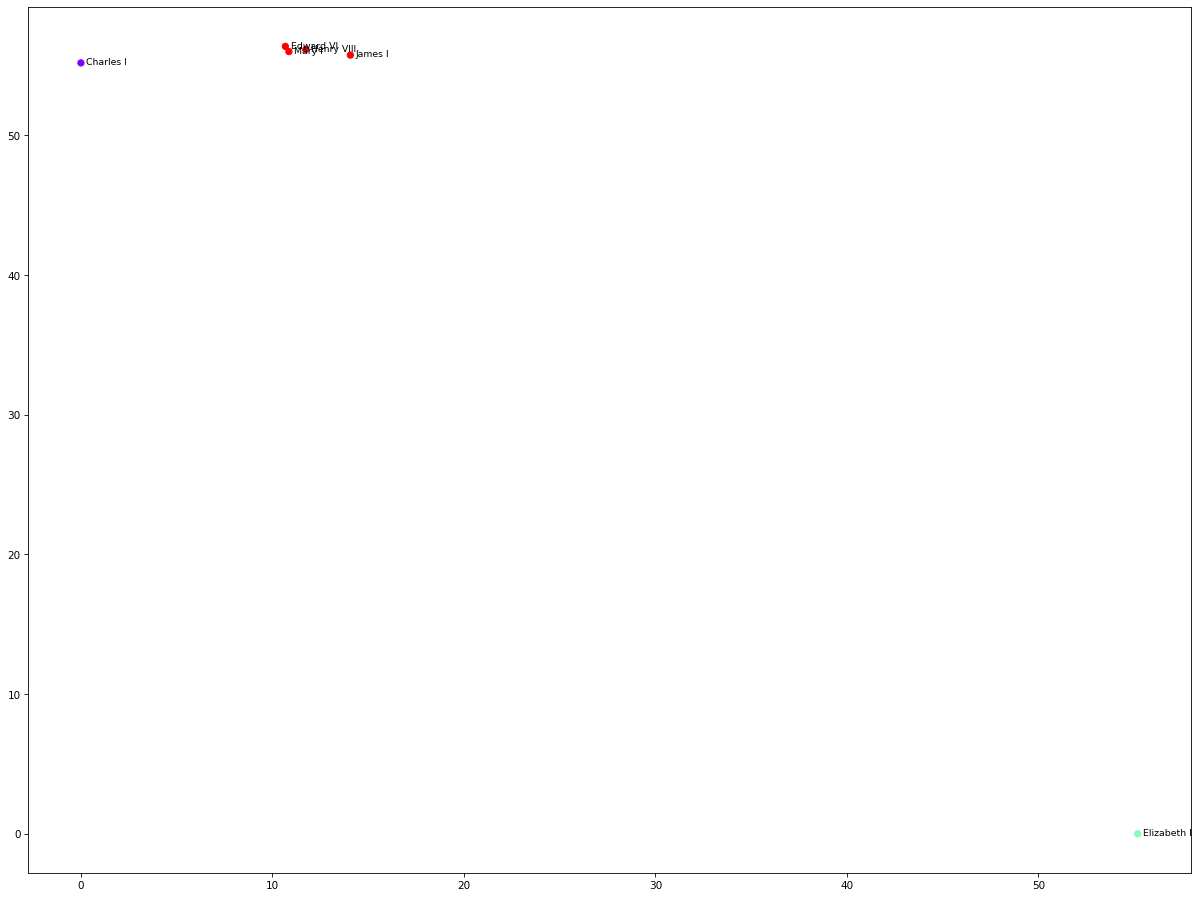

In [12]:
# vectorize
crown_list = list()
vec_data = list()

# preserve correct ordering?
for c in ["Henry VIII", "Edward VI", "Mary I","Elizabeth I","James I","Charles I"]:
    crown_list.append(c)
    data = ' '.join(five_gram_data[c])
    vec_data.append(data)

# re-establisher simple vectorizer
vectorizer = CountVectorizer(
    input='content',
    lowercase=True)

dtm = vectorizer.fit_transform(vec_data)
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=3)
X = kmeans.fit_transform(dtm)

klabels = kmeans.labels_

print("Crown: Class")
print("-------------------")
for i, l in enumerate(klabels):
    print("{0}: {1}".format(crown_list[i], l))

# graph
centroids = kmeans.cluster_centers_
centers = np.array(centroids)

#hang on...
# plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')

fig = plt.figure(figsize=(20, 15), dpi=75)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')

# add labels
for i, w in enumerate(crown_list):
    plt.annotate(w, xy = (X[i,0],X[i,1]), xytext = (5, 5),size=9,
                 textcoords = 'offset points', ha = 'left', va = 'top')

plt.savefig('ccp-5gram-kmeans-scatter.png')